In [3]:
import numpy as np
import pyreadr
import scvelo as scv
import numpy as np
import pandas as pd

# Load functions

In [4]:
def process_data(adata,result_E,result_A):
    obs_index=[]
    for ele in adata.obs.index:
        a=ele.split(':')[1]
        a=a.replace("x","-1")
        obs_index.append(a)
    adata.obs.index = obs_index
    
    adata_dict={}
    for i in range(0,len(adata.obs.index)):
        adata_dict[adata.obs.index[i]]=str(i)
    inter = (result_A.columns & result_E.columns & adata.obs.index)
    row_index=[]
    for ele in inter:
        row_index.append(int(adata_dict[ele]))
    len(row_index)
    
    adata_dict={}
    for i in range(0,len(adata.var.index)):
        adata_dict[adata.var.index[i]]=str(i)
    inter = (result_A.index & result_E.index & adata.var.index)
    col_index=[]
    for ele in inter:
        col_index.append(int(adata_dict[ele]))
    len(col_index)
    
    pdata = adata[row_index,col_index]
    return pdata


def calculate_velocyto(pdata):
    # Set up
    scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
    scv.settings.presenter_view = True  # set max width size for presenter view
    scv.set_figure_params('scvelo')  # for beautified visualization
    #Preprocess the Data
    #Most likely won't run since we will pass in the processed data 
    scv.pp.normalize_per_cell(pdata)
    scv.pp.log1p(pdata)
    scv.pp.moments(pdata, n_pcs=30, n_neighbors=30)
    
    #Estimate RNA velocity
    scv.tl.velocity(pdata)
    return pdata

def calculate_GAS(velocity_obj, rna_data, atac_data):
    
    velocity = pd.DataFrame(velocity_obj.layers['velocity'].T,index = velocity_obj.var.index,columns = velocity_obj.obs.index)

    #calculate weights
    rank_cell = velocity.rank(axis=0)
    rank_gene = velocity.rank(axis=1)
    rank_cell[velocity > 0] = rank_cell.shape[0] - rank_cell[velocity > 0]
    rank_cell[velocity < 0] = rank_cell[velocity < 0] - 1
    rank_cell[velocity == 0] = 0
    rank_gene[velocity > 0] = rank_gene.shape[1] - rank_gene[velocity > 0]
    rank_gene[velocity < 0] = rank_gene[velocity < 0] - 1
    rank_gene[velocity == 0] = 0
    cell_posi_num = (velocity > 0).sum(axis = 0)
    cell_nega_num = (velocity < 0).sum(axis = 0)
    gene_posi_num = (velocity > 0).sum(axis = 1)
    gene_nega_num = (velocity < 0).sum(axis = 1)
    weights = ((rank_cell ** 2 + rank_gene ** 2) / (((velocity > 0)*cell_posi_num + (velocity < 0)*cell_nega_num) ** 2 + np.transpose(np.transpose(velocity > 0)*gene_posi_num + np.transpose(velocity < 0)*gene_nega_num) ** 2 + (velocity == 0))) ** 0.5
    
    #calculate GAS
    GAS = rna_data + ((1+weights) * atac_data)
    return GAS

# Load data

## Yuntao's example

In [6]:
loom_path = 'data/1_pbmc_unsorted_3k.loom'
E_path = 'data/1_pbmc_unsorted_3k_A.rds'
A_path = 'data/1_pbmc_unsorted_3k_E.rds'

loom_data = scv.read(loom_path, cache = True)
rna_data = pyreadr.read_r(E_path)[None]
atac_data = pyreadr.read_r(A_path)[None]
loom_data.var_names_make_unique()


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Xiaoying normalized RNA+ATAC

In [5]:
loom_path = 'data/1_pbmc_unsorted_3k.loom'
E_path = 'data/pbmc_3k_norm_sct.rds'
A_path = 'data/pbmc_3k_norm_atac.rds'

loom_data = scv.read(loom_path, cache = True)
rna_data = pyreadr.read_r(E_path)[None]
atac_data = pyreadr.read_r(A_path)[None]
loom_data.var_names_make_unique()


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Direct export Seurat's RNA + MAESTRO ATAC

In [ ]:
loom_path = 'data/1_pbmc_unsorted_3k.loom'
E_path = 'data/pbmc_3k_sct.rds'
A_path = 'data/pbmc_3k_maestero.rds'

loom_data = scv.read(loom_path, cache = True)
rna_data = pyreadr.read_r(E_path)[None]
atac_data = pyreadr.read_r(A_path)[None]
loom_data.var_names_make_unique()

# Process velo data

In [6]:
velo_data = process_data(loom_data, rna_data, atac_data)

# Calculate velocity

In [7]:
velo_result = calculate_velocyto(velo_data)

Trying to set attribute `.var` of view, copying.


Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Calculate GAS

In [8]:
velo_result

AnnData object with n_obs × n_vars = 2824 × 14530
    obs: 'Clusters', '_X', '_Y', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [9]:
gas_result = calculate_GAS(velo_result, rna_data, atac_data)

In [10]:
gas_result

,AAACAGCCAACAGGTG-1,AAACATGCAACAACAA-1,AAACCAACACAGCCTG-1,AAACCAACAGCAAGAT-1,AAACCAACATTGCGAC-1,AAACCGAAGCACAGCC-1,AAACCGCGTAATTAGC-1,AAACCGCGTCACGAAC-1,AAACCGGCAGAGGGAG-1,AAACCGGCAGGGAGGA-1,...,TTTGGTGCATAATGTC-1,TTTGGTGCATGAGCAG-1,TTTGTCCCAGCTTAGC-1,TTTGTCCCATAATCGT-1,TTTGTCTAGCATGTTA-1,TTTGTCTAGGAGGACT-1,TTTGTCTAGTCTATGA-1,TTTGTGGCAGCACGAA-1,TTTGTGGCATCGCTCC-1,TTTGTGTTCATGCGTG-1
A1BG,0.001592,0.000365,0.000251,0.000000,0.000256,0.000222,0.0,0.000000,0.000000e+00,0.0,...,0.000241,0.000368,0.000182,0.000124,0.000591,0.0,0.0,0.000000,0.000000,0.000000
A1BG-AS1,0.001075,0.001147,0.001030,0.000000,0.001472,0.001276,0.0,0.000000,0.000000e+00,0.0,...,0.001082,0.001086,0.000977,0.000578,0.001752,0.0,0.0,0.000000,0.000000,0.000000
A2M,0.000022,0.000000,0.000072,0.000000,0.000000,0.000000,0.0,0.000000,3.681890e-03,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000048,0.003042,0.012995
A2M-AS1,0.000427,0.003156,0.001070,0.000000,0.000000,0.000000,0.0,0.000003,3.205965e-03,0.0,...,0.000000,0.000000,0.000000,0.000003,0.000000,0.0,0.0,0.003282,0.008003,0.000764
A2ML1,0.000000,0.000006,0.000000,0.000000,0.000000,0.000000,0.0,0.000037,0.000000e+00,0.0,...,0.000000,0.000000,0.000000,0.000014,0.000000,0.0,0.0,0.000034,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,0.000000,0.001809,0.000782,0.000615,0.000690,0.001379,0.0,0.000680,5.350352e-04,0.0,...,0.000000,0.001183,0.000000,0.000377,0.001417,0.0,0.0,0.000729,0.000000,0.000000
ZYG11A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000042,4.194956e-07,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
ZYG11B,0.006449,0.000000,0.002680,0.001800,0.000000,0.004789,0.0,0.002493,1.633415e-03,0.0,...,0.000006,0.002857,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
ZYX,0.000000,0.000197,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,7.366641e-03,0.0,...,0.000000,0.000000,0.000000,0.002601,0.002438,0.0,0.0,0.000000,0.002839,0.000000


# Save GAS matrix to rds

In [13]:
gas_result.shape

(14744, 2824)

In [14]:
pyreadr.write_rds("data/pbmc_3k_gas.rds", gas_result)


In [15]:
gas_result.to_csv('data/pbmc_3k_gas.csv', index=True)

# Visualization

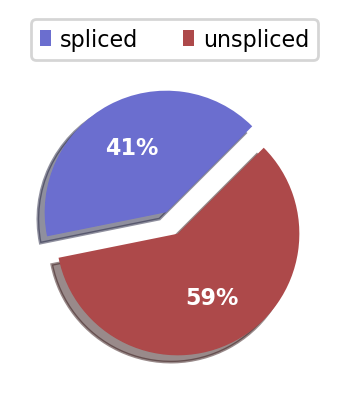

In [42]:
scv.pl.proportions(velo_result)

In [43]:
scv.pl.velocity_embedding(velo_result, basis='pca')

computing velocity embedding


ValueError: You need to run `tl.velocity_graph` first to compute cosine correlations.

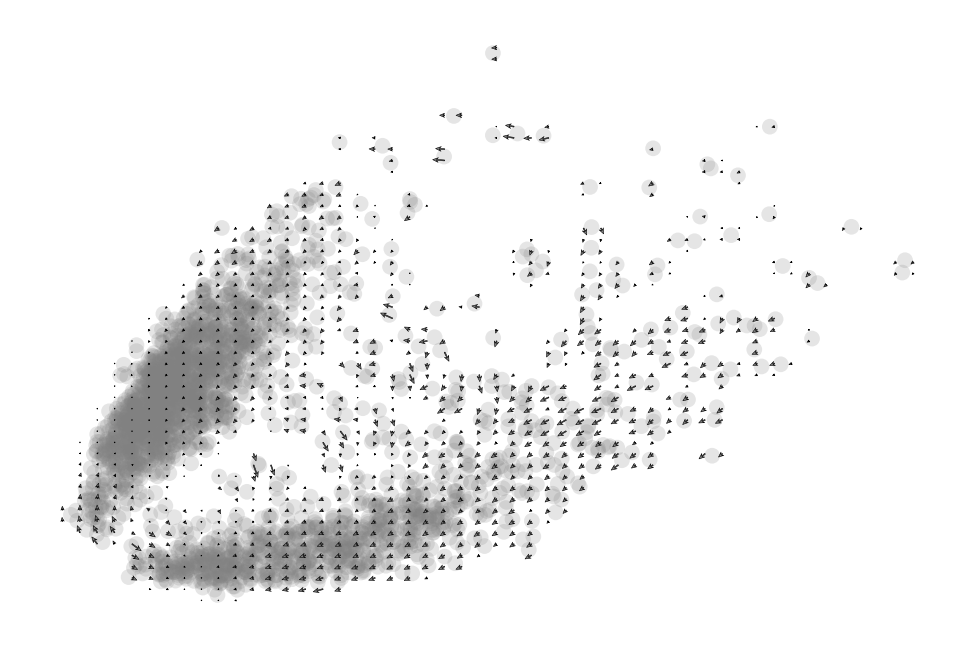

In [27]:
scv.pl.velocity_embedding_grid(velo_result, basis='pca')

In [28]:
scv.pl.velocity_embedding_stream(velo_result, basis='pca')

computing velocity embedding


ValueError: You need to run `tl.velocity_graph` first to compute cosine correlations.

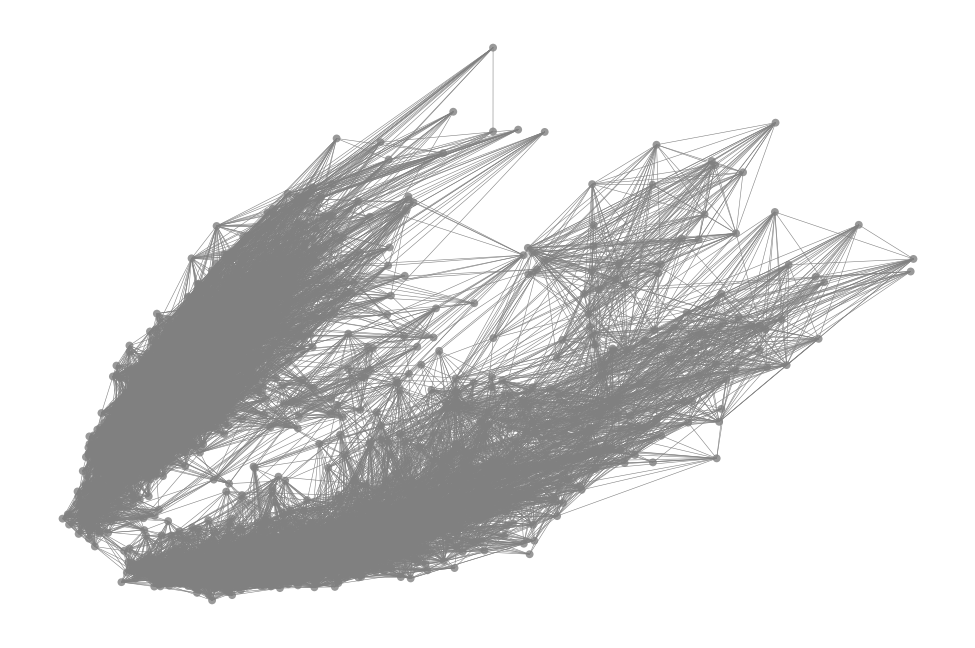

In [36]:
scv.pl.velocity_graph(velo_result)

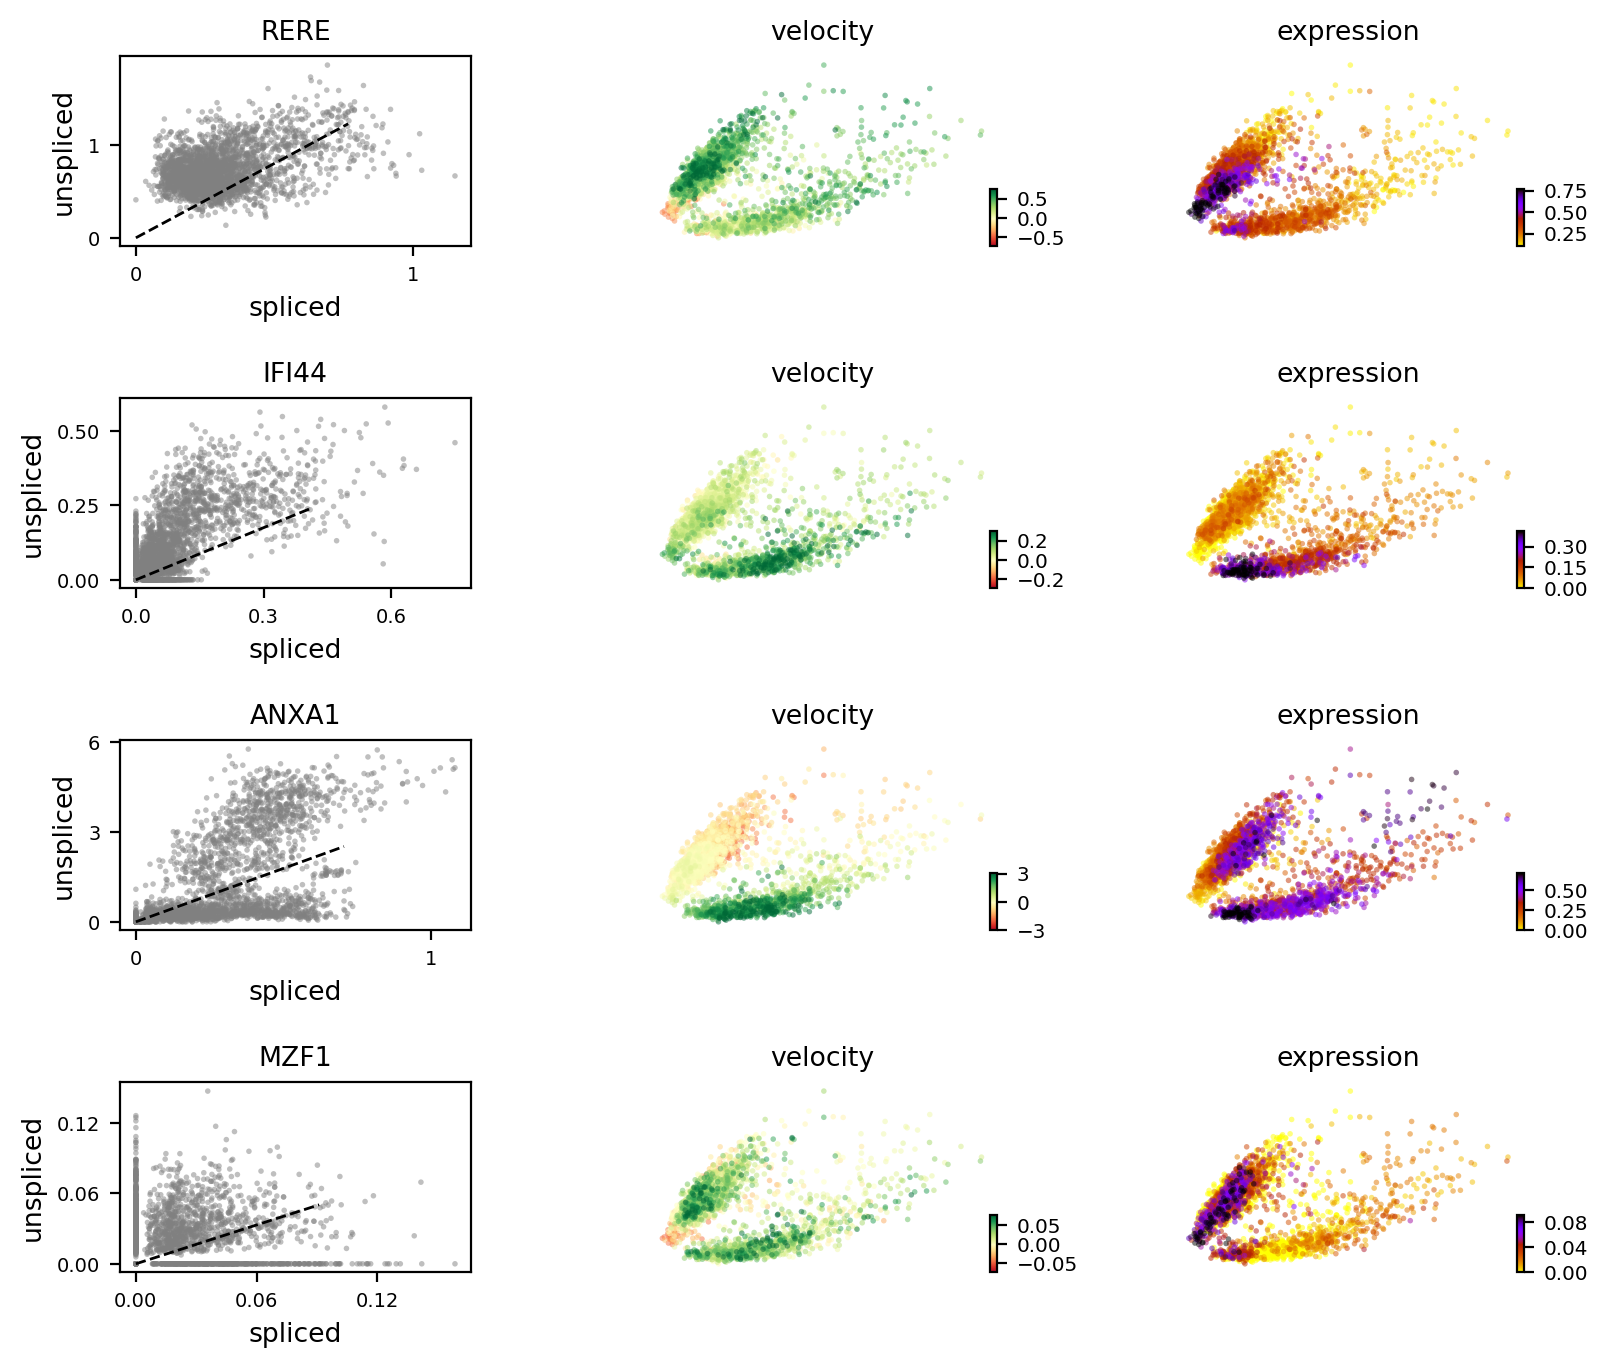

In [50]:
scv.pl.velocity(velo_result, var_names=['RERE', 'IFI44','ANXA1','MZF1'], ncols=1)